In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torchsummary
import os
import argparse
from fastai.data.external import untar_data, URLs
from torchvision.datasets import ImageFolder

import torchvision.transforms as tt

import pickle

In [2]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
# Transformations
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)

# Load CIFAR-10 test set
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)


# Classes in CIFAR-10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100%|██████████| 170498071/170498071 [00:06<00:00, 26926156.14it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3,
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample


    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv = conv3x3(3, 64)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 64, layers[0])
        self.layer2 = self.make_layer(block, 64, layers[1], 2)
        self.layer3 = self.make_layer(block, 128, layers[2], 2)
        self.layer4 = self.make_layer(block, 256, layers[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.fc(out)
        return out

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
res = ResNet(ResidualBlock, [3,4,6,2]).to(device)

cuda:0


In [5]:
torchsummary.summary(res, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
    ResidualBlock-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,864
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
           Conv2d-14           [-1, 64,

In [9]:
from timeit import default_timer as timer
from tqdm import tqdm
epochs = 50
torch.manual_seed(42)
torch.cuda.manual_seed(42)
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing

    def forward(self, input, target):
        log_prob = F.log_softmax(input, dim=-1)
        weight = input.new_ones(input.size()) * self.smoothing / (input.size(-1) - 1.)
        weight.scatter_(-1, target.unsqueeze(-1), (1. - self.smoothing))
        loss = (-weight * log_prob).sum(dim=-1).mean()
        return loss
loss_fn = LabelSmoothingCrossEntropy(smoothing=0.05)

# Optimizer
optimizer = optim.AdamW(res.parameters(), lr=0.001, weight_decay=0.01)

# Scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-6)


def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    return correct



train_time_start = timer()

for epoch in range(epochs):
    epoch_start = timer()

    # Train
    res.train()
    running_loss = 0.0
    running_correct = 0
    for images, labels in tqdm(trainloader, desc=f"Epoch {epoch + 1}/{epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = res(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_correct += calculate_accuracy(outputs, labels)


    scheduler.step()
    epoch_duration = timer() - epoch_start
    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = running_correct / len(trainloader.dataset)

    print(f"Epoch {epoch + 1}/{epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}, Duration: {epoch_duration:.2f}s")

    # Test
    res.eval()
    running_loss = 0.0
    running_correct = 0
    with torch.inference_mode():
        for images, labels in tqdm(testloader, desc=f"Epoch {epoch + 1}/{epochs} - Test"):
            images, labels = images.to(device), labels.to(device)

            outputs = res(images)
            loss = loss_fn(outputs, labels)

            running_loss += loss.item()
            running_correct += calculate_accuracy(outputs, labels)

    val_loss = running_loss / len(testloader)
    val_accuracy = running_correct / len(testloader.dataset)

    print(f"Test - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")

# End of training
train_time_end = timer()
total_train_time = train_time_end - train_time_start
print(f"Total training time: {total_train_time:.2f}s")

Epoch 1/50 - Training: 100%|██████████| 1563/1563 [01:41<00:00, 15.33it/s]


Epoch 1/50 - Loss: 1.3267, Accuracy: 0.5844, Duration: 101.94s


Epoch 1/50 - Test: 100%|██████████| 313/313 [00:04<00:00, 67.86it/s]


Test - Loss: 1.1456, Accuracy: 0.6583


Epoch 2/50 - Training: 100%|██████████| 1563/1563 [01:40<00:00, 15.54it/s]


Epoch 2/50 - Loss: 1.2151, Accuracy: 0.6333, Duration: 100.56s


Epoch 2/50 - Test: 100%|██████████| 313/313 [00:04<00:00, 65.64it/s]


Test - Loss: 1.0119, Accuracy: 0.7216


Epoch 3/50 - Training: 100%|██████████| 1563/1563 [01:40<00:00, 15.50it/s]


Epoch 3/50 - Loss: 1.1033, Accuracy: 0.6865, Duration: 100.85s


Epoch 3/50 - Test: 100%|██████████| 313/313 [00:04<00:00, 67.23it/s]


Test - Loss: 0.9111, Accuracy: 0.7650


Epoch 4/50 - Training: 100%|██████████| 1563/1563 [01:41<00:00, 15.42it/s]


Epoch 4/50 - Loss: 1.0198, Accuracy: 0.7236, Duration: 101.37s


Epoch 4/50 - Test: 100%|██████████| 313/313 [00:04<00:00, 65.58it/s]


Test - Loss: 0.8484, Accuracy: 0.7885


Epoch 5/50 - Training: 100%|██████████| 1563/1563 [01:42<00:00, 15.29it/s]


Epoch 5/50 - Loss: 0.9513, Accuracy: 0.7493, Duration: 102.22s


Epoch 5/50 - Test: 100%|██████████| 313/313 [00:04<00:00, 63.82it/s]


Test - Loss: 0.7783, Accuracy: 0.8128


Epoch 6/50 - Training: 100%|██████████| 1563/1563 [01:42<00:00, 15.27it/s]


Epoch 6/50 - Loss: 0.8946, Accuracy: 0.7729, Duration: 102.36s


Epoch 6/50 - Test: 100%|██████████| 313/313 [00:05<00:00, 55.17it/s]


Test - Loss: 0.7448, Accuracy: 0.8302


Epoch 7/50 - Training: 100%|██████████| 1563/1563 [01:41<00:00, 15.42it/s]


Epoch 7/50 - Loss: 0.8445, Accuracy: 0.7923, Duration: 101.35s


Epoch 7/50 - Test: 100%|██████████| 313/313 [00:05<00:00, 55.59it/s]


Test - Loss: 0.7025, Accuracy: 0.8469


Epoch 8/50 - Training: 100%|██████████| 1563/1563 [01:39<00:00, 15.64it/s]


Epoch 8/50 - Loss: 0.7971, Accuracy: 0.8120, Duration: 99.95s


Epoch 8/50 - Test: 100%|██████████| 313/313 [00:05<00:00, 56.40it/s]


Test - Loss: 0.6708, Accuracy: 0.8578


Epoch 9/50 - Training: 100%|██████████| 1563/1563 [01:41<00:00, 15.41it/s]


Epoch 9/50 - Loss: 0.7707, Accuracy: 0.8207, Duration: 101.42s


Epoch 9/50 - Test: 100%|██████████| 313/313 [00:05<00:00, 60.60it/s]


Test - Loss: 0.6547, Accuracy: 0.8657


Epoch 10/50 - Training: 100%|██████████| 1563/1563 [01:42<00:00, 15.31it/s]


Epoch 10/50 - Loss: 0.7599, Accuracy: 0.8281, Duration: 102.07s


Epoch 10/50 - Test: 100%|██████████| 313/313 [00:04<00:00, 66.99it/s]


Test - Loss: 0.6483, Accuracy: 0.8692


Epoch 11/50 - Training: 100%|██████████| 1563/1563 [01:42<00:00, 15.28it/s]


Epoch 11/50 - Loss: 0.8768, Accuracy: 0.7800, Duration: 102.29s


Epoch 11/50 - Test: 100%|██████████| 313/313 [00:04<00:00, 65.19it/s]


Test - Loss: 0.7382, Accuracy: 0.8315


Epoch 12/50 - Training: 100%|██████████| 1563/1563 [01:42<00:00, 15.19it/s]


Epoch 12/50 - Loss: 0.8554, Accuracy: 0.7901, Duration: 102.87s


Epoch 12/50 - Test: 100%|██████████| 313/313 [00:04<00:00, 66.27it/s]


Test - Loss: 0.7339, Accuracy: 0.8342


Epoch 13/50 - Training: 100%|██████████| 1563/1563 [01:44<00:00, 15.01it/s]


Epoch 13/50 - Loss: 0.8273, Accuracy: 0.7993, Duration: 104.12s


Epoch 13/50 - Test: 100%|██████████| 313/313 [00:05<00:00, 58.26it/s]


Test - Loss: 0.7111, Accuracy: 0.8447


Epoch 14/50 - Training: 100%|██████████| 1563/1563 [01:42<00:00, 15.31it/s]


Epoch 14/50 - Loss: 0.7895, Accuracy: 0.8155, Duration: 102.12s


Epoch 14/50 - Test: 100%|██████████| 313/313 [00:05<00:00, 55.15it/s]


Test - Loss: 0.6527, Accuracy: 0.8655


Epoch 15/50 - Training: 100%|██████████| 1563/1563 [01:42<00:00, 15.30it/s]


Epoch 15/50 - Loss: 0.7498, Accuracy: 0.8328, Duration: 102.15s


Epoch 15/50 - Test: 100%|██████████| 313/313 [00:05<00:00, 56.50it/s]


Test - Loss: 0.6189, Accuracy: 0.8778


Epoch 16/50 - Training: 100%|██████████| 1563/1563 [01:43<00:00, 15.15it/s]


Epoch 16/50 - Loss: 0.7152, Accuracy: 0.8457, Duration: 103.19s


Epoch 16/50 - Test: 100%|██████████| 313/313 [00:04<00:00, 65.54it/s]


Test - Loss: 0.5987, Accuracy: 0.8880


Epoch 17/50 - Training: 100%|██████████| 1563/1563 [01:42<00:00, 15.26it/s]


Epoch 17/50 - Loss: 0.6782, Accuracy: 0.8595, Duration: 102.42s


Epoch 17/50 - Test: 100%|██████████| 313/313 [00:04<00:00, 66.08it/s]


Test - Loss: 0.5816, Accuracy: 0.8952


Epoch 18/50 - Training: 100%|██████████| 1563/1563 [01:41<00:00, 15.38it/s]


Epoch 18/50 - Loss: 0.6481, Accuracy: 0.8707, Duration: 101.63s


Epoch 18/50 - Test: 100%|██████████| 313/313 [00:04<00:00, 66.61it/s]


Test - Loss: 0.5669, Accuracy: 0.9005


Epoch 19/50 - Training: 100%|██████████| 1563/1563 [01:44<00:00, 14.98it/s]


Epoch 19/50 - Loss: 0.6234, Accuracy: 0.8812, Duration: 104.32s


Epoch 19/50 - Test: 100%|██████████| 313/313 [00:05<00:00, 61.39it/s]


Test - Loss: 0.5515, Accuracy: 0.9081


Epoch 20/50 - Training: 100%|██████████| 1563/1563 [01:42<00:00, 15.19it/s]


Epoch 20/50 - Loss: 0.6099, Accuracy: 0.8863, Duration: 102.87s


Epoch 20/50 - Test: 100%|██████████| 313/313 [00:05<00:00, 56.51it/s]


Test - Loss: 0.5471, Accuracy: 0.9109


Epoch 21/50 - Training: 100%|██████████| 1563/1563 [01:41<00:00, 15.44it/s]


Epoch 21/50 - Loss: 0.7370, Accuracy: 0.8372, Duration: 101.21s


Epoch 21/50 - Test: 100%|██████████| 313/313 [00:05<00:00, 54.55it/s]


Test - Loss: 0.6557, Accuracy: 0.8657


Epoch 22/50 - Training: 100%|██████████| 1563/1563 [01:42<00:00, 15.24it/s]


Epoch 22/50 - Loss: 0.7325, Accuracy: 0.8380, Duration: 102.60s


Epoch 22/50 - Test: 100%|██████████| 313/313 [00:05<00:00, 58.26it/s]


Test - Loss: 0.7166, Accuracy: 0.8438


Epoch 23/50 - Training: 100%|██████████| 1563/1563 [01:41<00:00, 15.34it/s]


Epoch 23/50 - Loss: 0.7092, Accuracy: 0.8469, Duration: 101.92s


Epoch 23/50 - Test: 100%|██████████| 313/313 [00:04<00:00, 66.78it/s]


Test - Loss: 0.6123, Accuracy: 0.8817


Epoch 24/50 - Training: 100%|██████████| 1563/1563 [01:41<00:00, 15.47it/s]


Epoch 24/50 - Loss: 0.6860, Accuracy: 0.8562, Duration: 101.02s


Epoch 24/50 - Test: 100%|██████████| 313/313 [00:04<00:00, 64.89it/s]


Test - Loss: 0.5866, Accuracy: 0.8928


Epoch 25/50 - Training: 100%|██████████| 1563/1563 [01:41<00:00, 15.40it/s]


Epoch 25/50 - Loss: 0.6545, Accuracy: 0.8680, Duration: 101.53s


Epoch 25/50 - Test: 100%|██████████| 313/313 [00:04<00:00, 65.34it/s]


Test - Loss: 0.5686, Accuracy: 0.8976


Epoch 26/50 - Training: 100%|██████████| 1563/1563 [01:42<00:00, 15.28it/s]


Epoch 26/50 - Loss: 0.6235, Accuracy: 0.8839, Duration: 102.29s


Epoch 26/50 - Test: 100%|██████████| 313/313 [00:04<00:00, 65.24it/s]


Test - Loss: 0.5470, Accuracy: 0.9066


Epoch 27/50 - Training: 100%|██████████| 1563/1563 [01:42<00:00, 15.22it/s]


Epoch 27/50 - Loss: 0.5947, Accuracy: 0.8919, Duration: 102.72s


Epoch 27/50 - Test: 100%|██████████| 313/313 [00:05<00:00, 55.28it/s]


Test - Loss: 0.5438, Accuracy: 0.9097


Epoch 28/50 - Training: 100%|██████████| 1563/1563 [01:40<00:00, 15.50it/s]


Epoch 28/50 - Loss: 0.5673, Accuracy: 0.9034, Duration: 100.85s


Epoch 28/50 - Test: 100%|██████████| 313/313 [00:05<00:00, 55.99it/s]


Test - Loss: 0.5243, Accuracy: 0.9168


Epoch 29/50 - Training: 100%|██████████| 1563/1563 [01:40<00:00, 15.56it/s]


Epoch 29/50 - Loss: 0.5479, Accuracy: 0.9112, Duration: 100.43s


Epoch 29/50 - Test: 100%|██████████| 313/313 [00:05<00:00, 56.55it/s]


Test - Loss: 0.5125, Accuracy: 0.9221


Epoch 30/50 - Training: 100%|██████████| 1563/1563 [01:41<00:00, 15.47it/s]


Epoch 30/50 - Loss: 0.5350, Accuracy: 0.9161, Duration: 101.07s


Epoch 30/50 - Test: 100%|██████████| 313/313 [00:05<00:00, 61.15it/s]


Test - Loss: 0.5122, Accuracy: 0.9233


Epoch 31/50 - Training: 100%|██████████| 1563/1563 [01:40<00:00, 15.52it/s]


Epoch 31/50 - Loss: 0.6632, Accuracy: 0.8663, Duration: 100.69s


Epoch 31/50 - Test: 100%|██████████| 313/313 [00:04<00:00, 63.39it/s]


Test - Loss: 0.5810, Accuracy: 0.8924


Epoch 32/50 - Training: 100%|██████████| 1563/1563 [01:40<00:00, 15.57it/s]


Epoch 32/50 - Loss: 0.6622, Accuracy: 0.8655, Duration: 100.37s


Epoch 32/50 - Test: 100%|██████████| 313/313 [00:04<00:00, 66.52it/s]


Test - Loss: 0.5901, Accuracy: 0.8940


Epoch 33/50 - Training: 100%|██████████| 1563/1563 [01:39<00:00, 15.64it/s]


Epoch 33/50 - Loss: 0.6412, Accuracy: 0.8748, Duration: 99.97s


Epoch 33/50 - Test: 100%|██████████| 313/313 [00:04<00:00, 66.67it/s]


Test - Loss: 0.5544, Accuracy: 0.9031


Epoch 34/50 - Training: 100%|██████████| 1563/1563 [01:43<00:00, 15.16it/s]


Epoch 34/50 - Loss: 0.6207, Accuracy: 0.8822, Duration: 103.13s


Epoch 34/50 - Test: 100%|██████████| 313/313 [00:04<00:00, 67.52it/s]


Test - Loss: 0.5676, Accuracy: 0.9021


Epoch 35/50 - Training: 100%|██████████| 1563/1563 [01:41<00:00, 15.41it/s]


Epoch 35/50 - Loss: 0.5913, Accuracy: 0.8938, Duration: 101.44s


Epoch 35/50 - Test: 100%|██████████| 313/313 [00:04<00:00, 66.56it/s]


Test - Loss: 0.5429, Accuracy: 0.9099


Epoch 36/50 - Training: 100%|██████████| 1563/1563 [01:43<00:00, 15.16it/s]


Epoch 36/50 - Loss: 0.5679, Accuracy: 0.9034, Duration: 103.08s


Epoch 36/50 - Test: 100%|██████████| 313/313 [00:05<00:00, 61.67it/s]


Test - Loss: 0.5269, Accuracy: 0.9177


Epoch 37/50 - Training: 100%|██████████| 1563/1563 [01:41<00:00, 15.47it/s]


Epoch 37/50 - Loss: 0.5405, Accuracy: 0.9137, Duration: 101.02s


Epoch 37/50 - Test: 100%|██████████| 313/313 [00:05<00:00, 56.03it/s]


Test - Loss: 0.5294, Accuracy: 0.9151


Epoch 38/50 - Training: 100%|██████████| 1563/1563 [01:40<00:00, 15.59it/s]


Epoch 38/50 - Loss: 0.5200, Accuracy: 0.9225, Duration: 100.29s


Epoch 38/50 - Test: 100%|██████████| 313/313 [00:05<00:00, 55.22it/s]


Test - Loss: 0.5091, Accuracy: 0.9245


Epoch 39/50 - Training: 100%|██████████| 1563/1563 [01:40<00:00, 15.49it/s]


Epoch 39/50 - Loss: 0.5010, Accuracy: 0.9292, Duration: 100.94s


Epoch 39/50 - Test: 100%|██████████| 313/313 [00:05<00:00, 56.80it/s]


Test - Loss: 0.4999, Accuracy: 0.9296


Epoch 40/50 - Training: 100%|██████████| 1563/1563 [01:41<00:00, 15.43it/s]


Epoch 40/50 - Loss: 0.4901, Accuracy: 0.9345, Duration: 101.28s


Epoch 40/50 - Test: 100%|██████████| 313/313 [00:05<00:00, 61.01it/s]


Test - Loss: 0.4971, Accuracy: 0.9303


Epoch 41/50 - Training: 100%|██████████| 1563/1563 [01:43<00:00, 15.13it/s]


Epoch 41/50 - Loss: 0.6097, Accuracy: 0.8881, Duration: 103.32s


Epoch 41/50 - Test: 100%|██████████| 313/313 [00:04<00:00, 64.66it/s]


Test - Loss: 0.5657, Accuracy: 0.9037


Epoch 42/50 - Training: 100%|██████████| 1563/1563 [01:43<00:00, 15.14it/s]


Epoch 42/50 - Loss: 0.6143, Accuracy: 0.8851, Duration: 103.25s


Epoch 42/50 - Test: 100%|██████████| 313/313 [00:04<00:00, 65.41it/s]


Test - Loss: 0.5824, Accuracy: 0.8962


Epoch 43/50 - Training: 100%|██████████| 1563/1563 [01:43<00:00, 15.12it/s]


Epoch 43/50 - Loss: 0.6006, Accuracy: 0.8901, Duration: 103.39s


Epoch 43/50 - Test: 100%|██████████| 313/313 [00:04<00:00, 64.12it/s]


Test - Loss: 0.5604, Accuracy: 0.9024


Epoch 44/50 - Training: 100%|██████████| 1563/1563 [01:43<00:00, 15.11it/s]


Epoch 44/50 - Loss: 0.5858, Accuracy: 0.8957, Duration: 103.48s


Epoch 44/50 - Test: 100%|██████████| 313/313 [00:05<00:00, 55.70it/s]


Test - Loss: 0.5363, Accuracy: 0.9099


Epoch 45/50 - Training: 100%|██████████| 1563/1563 [01:42<00:00, 15.27it/s]


Epoch 45/50 - Loss: 0.5578, Accuracy: 0.9067, Duration: 102.38s


Epoch 45/50 - Test: 100%|██████████| 313/313 [00:05<00:00, 56.47it/s]


Test - Loss: 0.5293, Accuracy: 0.9168


Epoch 46/50 - Training: 100%|██████████| 1563/1563 [01:41<00:00, 15.40it/s]


Epoch 46/50 - Loss: 0.5323, Accuracy: 0.9152, Duration: 101.53s


Epoch 46/50 - Test: 100%|██████████| 313/313 [00:04<00:00, 63.04it/s]


Test - Loss: 0.5125, Accuracy: 0.9225


Epoch 47/50 - Training: 100%|██████████| 1563/1563 [01:41<00:00, 15.45it/s]


Epoch 47/50 - Loss: 0.5088, Accuracy: 0.9272, Duration: 101.18s


Epoch 47/50 - Test: 100%|██████████| 313/313 [00:04<00:00, 65.36it/s]


Test - Loss: 0.5112, Accuracy: 0.9239


Epoch 48/50 - Training: 100%|██████████| 1563/1563 [01:45<00:00, 14.75it/s]


Epoch 48/50 - Loss: 0.4812, Accuracy: 0.9373, Duration: 105.96s


Epoch 48/50 - Test: 100%|██████████| 313/313 [00:04<00:00, 66.07it/s]


Test - Loss: 0.4962, Accuracy: 0.9296


Epoch 49/50 - Training: 100%|██████████| 1563/1563 [01:41<00:00, 15.32it/s]


Epoch 49/50 - Loss: 0.4720, Accuracy: 0.9419, Duration: 102.00s


Epoch 49/50 - Test: 100%|██████████| 313/313 [00:05<00:00, 62.57it/s]


Test - Loss: 0.4906, Accuracy: 0.9324


Epoch 50/50 - Training: 100%|██████████| 1563/1563 [01:41<00:00, 15.37it/s]


Epoch 50/50 - Loss: 0.4606, Accuracy: 0.9464, Duration: 101.67s


Epoch 50/50 - Test: 100%|██████████| 313/313 [00:05<00:00, 55.23it/s]

Test - Loss: 0.4887, Accuracy: 0.9343
Total training time: 5353.53s


In [10]:
torch.save(res.state_dict(), 'resnet.pth')

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


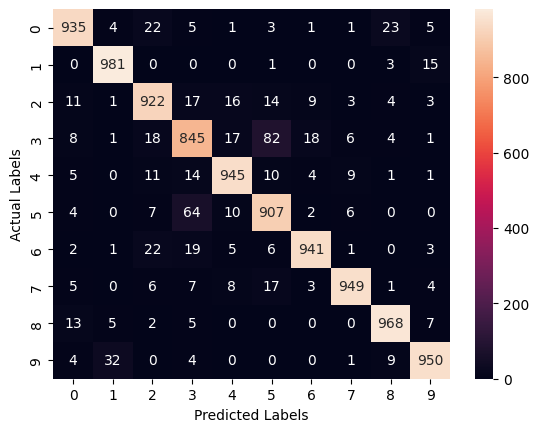

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
all_preds_alex = []
all_true_labels_alex = []

res.eval()
with torch.no_grad():
    for X, y in testloader:
        X, y = X.to(device), y.to(device)
        outputs = res(X)
        _, preds = torch.max(outputs, 1)
        all_preds_alex.extend(preds.cpu().numpy())
        all_true_labels_alex.extend(y.cpu().numpy())

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_true_labels_alex, all_preds_alex)

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

In [17]:
test_data_dict = '/content/cifar_test_nolabels.pkl'

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

test_data = unpickle(test_data_dict)

images = test_data[b'data']
images = images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
images = images.astype(np.float32) / 255.0
images_tensor = torch.tensor(images, dtype=torch.float32).to(device)
ids = test_data[b'ids']


In [19]:
test_data

{b'data': array([[133, 136, 136, ..., 226, 225, 224],
        [160, 177, 176, ...,  89,  89,  88],
        [255, 255, 255, ..., 211, 213, 215],
        ...,
        [ 29,  29,  45, ..., 156, 155, 154],
        [124, 123, 126, ...,  49,  49,  51],
        [255, 255, 255, ..., 250, 251, 255]], dtype=uint8),
 b'ids': array([   0,    1,    2, ..., 9997, 9998, 9999])}

In [20]:
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import Normalize, Compose
from torchvision.transforms.functional import to_tensor

test_data_dict = unpickle('/content/cifar_test_nolabels.pkl')
normalize = transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
# Reshape the images and normalize them
images = test_data_dict[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) / 255.0  # Reshape and normalize

# Apply the necessary transformations and ensure the tensor is of type float
transformed_images = torch.stack([normalize(to_tensor(img)).float() for img in images])

# Create a DataLoader
ids_list = test_data_dict[b'ids']
test_dataset = TensorDataset(transformed_images)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Make predictions
res.eval()
predictions = []

with torch.no_grad():
    for images in test_loader:
        images = images[0].to(device)
        outputs = res(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().tolist())

# Check if predictions and IDs match in length
assert len(ids_list) == len(predictions), "Mismatch between IDs and predictions length."

# Save predictions
submission_df = pd.DataFrame({'ID': ids_list, 'predicted_class': predictions})
csv_file_path = '/content/predictions3.csv'  # Adjust path as needed
submission_df.to_csv(csv_file_path, index=False)

print(f'Predictions saved to {csv_file_path}')

predictions

Predictions saved to /content/predictions3.csv


[8,
 8,
 8,
 0,
 8,
 8,
 8,
 7,
 8,
 8,
 8,
 4,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 1,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 0,
 8,
 8,
 1,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 0,
 0,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 0,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 8,
 8,
 8,
 8,
 8,
 9,
 8,
 6,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 0,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 0,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 0,
 1,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 0,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 0,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
